# Output Analysis

This file is used to analyze output.

## 1. Setting up the networks to analyse

In [275]:
import os

if not os.getcwd().endswith("pypsa-eur-climact"):
    %cd ../..
%pwd

'/Users/climact/pypsa/pypsa-eur-climact'

In [276]:
from pathlib import Path
import pypsa
import pandas as pd
import pylab

%matplotlib inline
pylab.rcParams["figure.figsize"] = (25, 6)
pd.set_option("display.width", 1000)

n_path = Path("analysis", "CANEurope_allam_false_nuc_phase_out_costs_up_v1_5_no_dac", "results")
n_name = "elec_s181_37m_lv1.5__3H_"

In [277]:
font = 13
def graph_display(n: dict[int, pd.DataFrame], kind: str = "plot", title: str = "", unit: str = ""):
    df = []
    for k, ni in n.items():
        ax = df.append(ni.sum(axis=1).rename(f"{k}"))
    df = pd.concat(df, axis=1)
    if kind == "plot":
        ax = df.sort_index().fillna(method="ffill").plot()
        ax.set_ylabel(unit, fontsize=font)
        ax.set_title(title, fontsize=font)
    elif kind == "bar":
        ax = df.plot.bar()
        ax.set_ylabel(unit, fontsize=font)
        ax.set_title(title, fontsize=font)
    elif kind == "hist":
        ax = df.plot.hist(alpha=0.8)
        ax.set_xlabel(unit, fontsize=font)
        ax.set_title(title, fontsize=font)
    else:
        raise RuntimeError
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def get_state_of_charge_t(n, carrier):
    df = n.storage_units_t.state_of_charge.T.reset_index()
    df = df.merge(n.storage_units.reset_index()[["carrier", "StorageUnit"]], on="StorageUnit")
    df = df.groupby(by="carrier").sum()
    del df["StorageUnit"]
    return df.T[[carrier]]

def get_e_t(n, carrier):
    df = n.stores_t.e.T.reset_index()
    df = df.merge(n.stores.reset_index()[["carrier", "Store"]], on="Store")
    df = df.groupby(by="carrier").sum()
    del df["Store"]
    return df.T[[carrier]]

In [278]:
years = [2030, 2035, 2040]
n = {}
for y in years:
    n[f"{y}"] = pypsa.Network(Path(n_path, "postnetworks", n_name + f"{y}.nc"))

INFO:pypsa.io:Imported network elec_s181_37m_lv1.5__3H_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s181_37m_lv1.5__3H_2035.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s181_37m_lv1.5__3H_2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## 2. Displaying installed capacities for power supply units

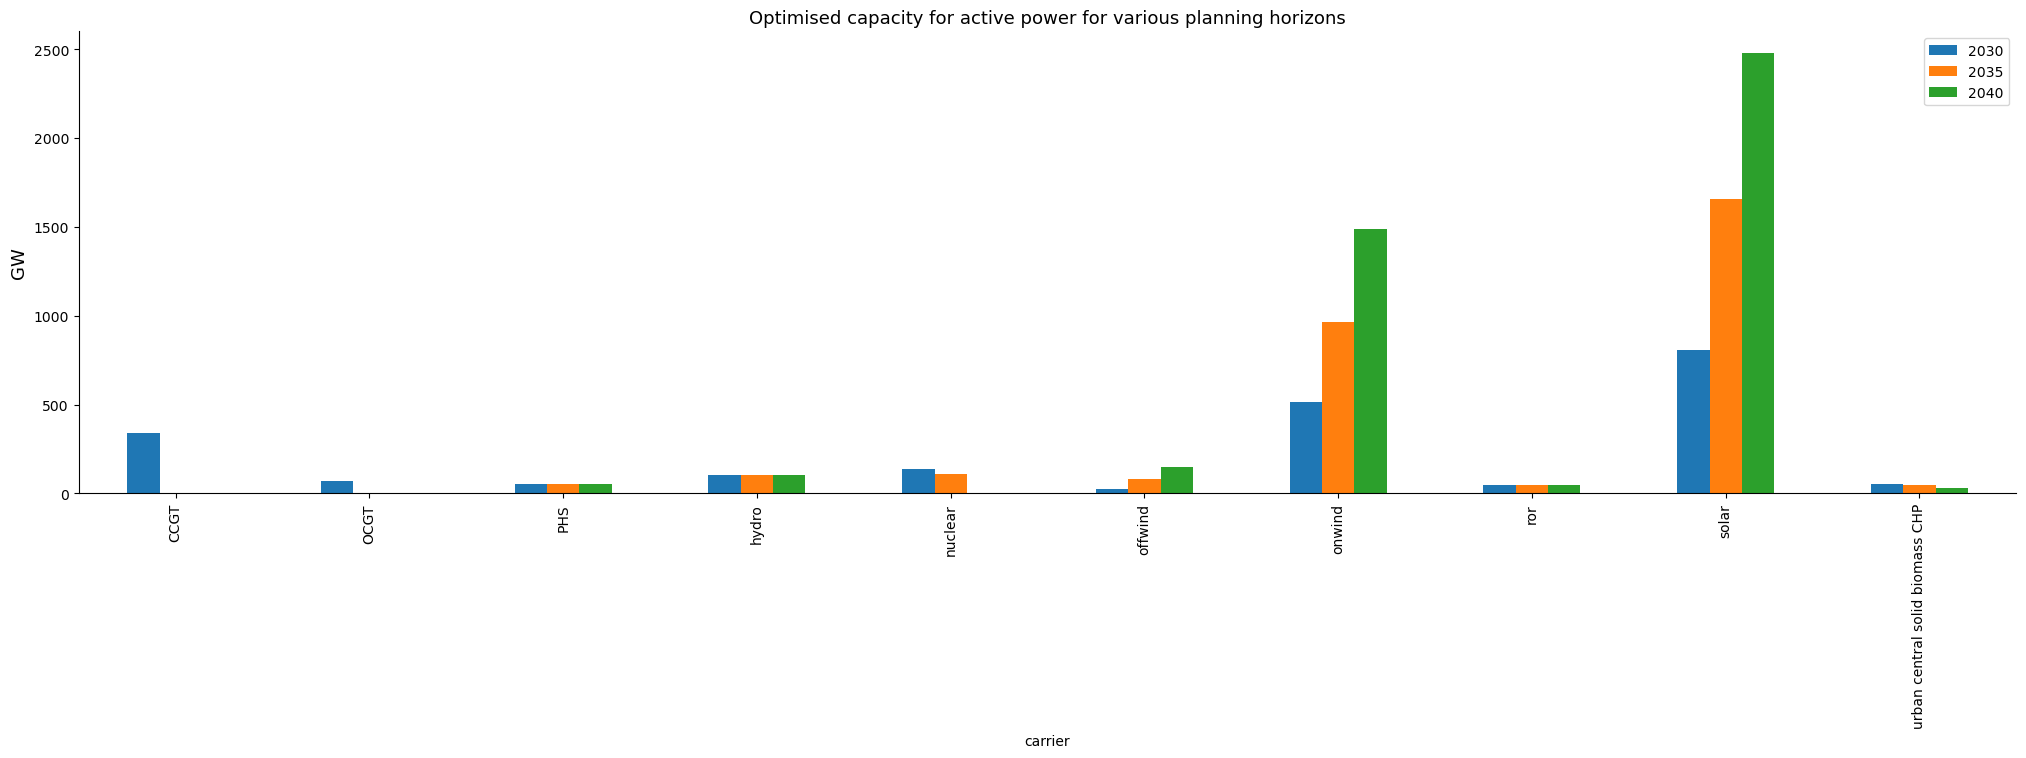

In [288]:
var = "p_nom_opt"
storage_exclude = ["H2 Electrolysis", "H2 Fuel Cell", "battery charger", "battery discharger", "home battery charger", "home battery discharger", "Haber-Bosch", "Sabatier", "ammonia cracker", "helmeth", "SMR", "SMR CC"]
gens = ["coal", "gas", "lignite", "uranium", "oil", "biomass"]
generators_carrier_exclude = storage_exclude + gens +["DC", "gas pipeline", "gas pipeline new", "CO2 pipeline", "H2 pipeline", "H2 pipeline retrofitted", "electricity distribution grid"]
renamer = {"offwind-dc": "offwind", "offwind-ac": "offwind", "solar rooftop": "solar"}

n_links = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum(), n[str(y)].storage_units.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[~n_y.index.isin(generators_carrier_exclude)]
    n_links[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]]/1e3 for k, ni in n_links.items()}, kind="bar", title="Optimised capacity for active power for various planning horizons", unit="GW")

## 3. Displaying installed capacities for power balance units

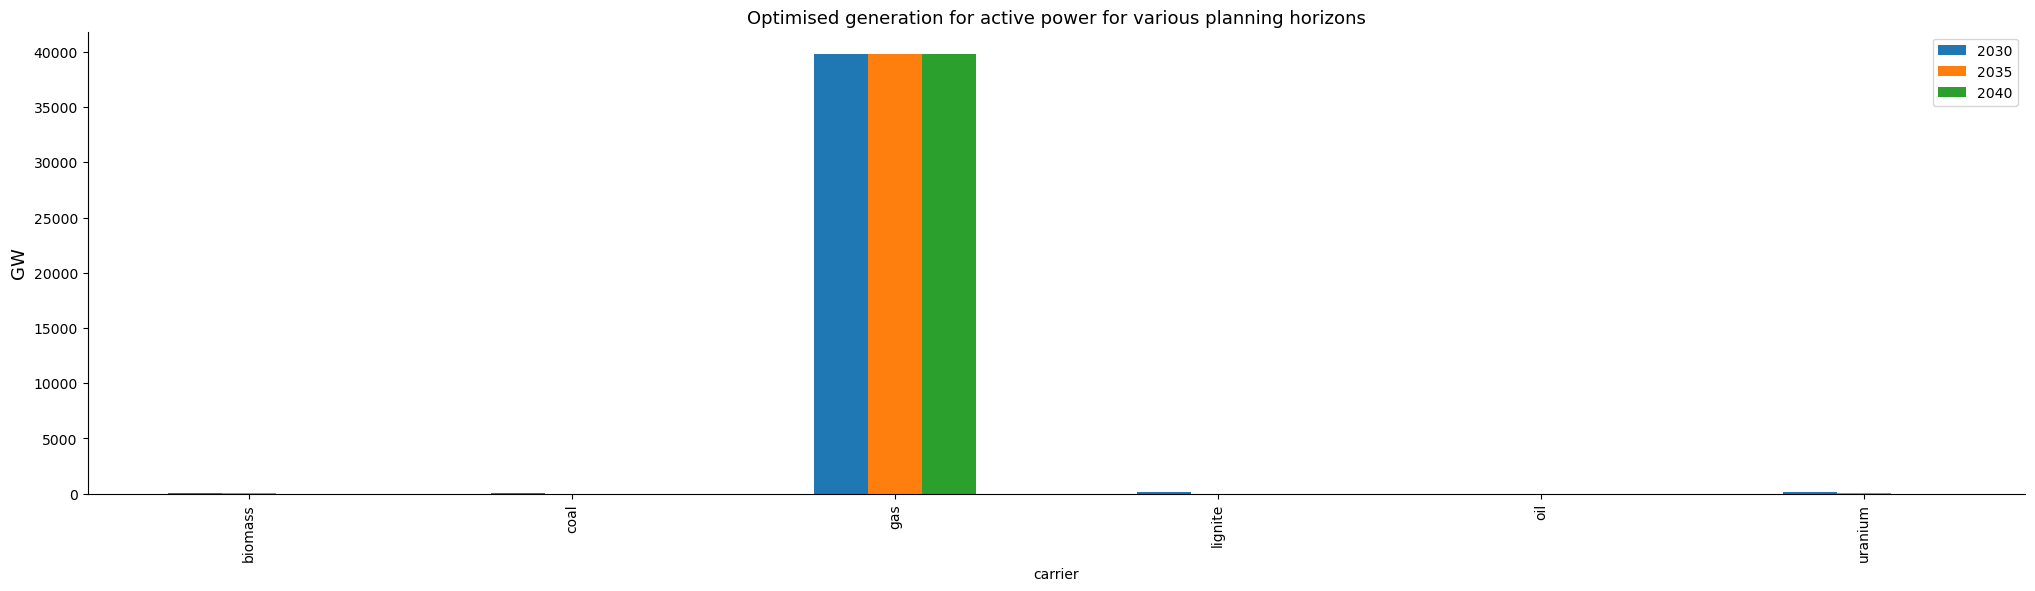

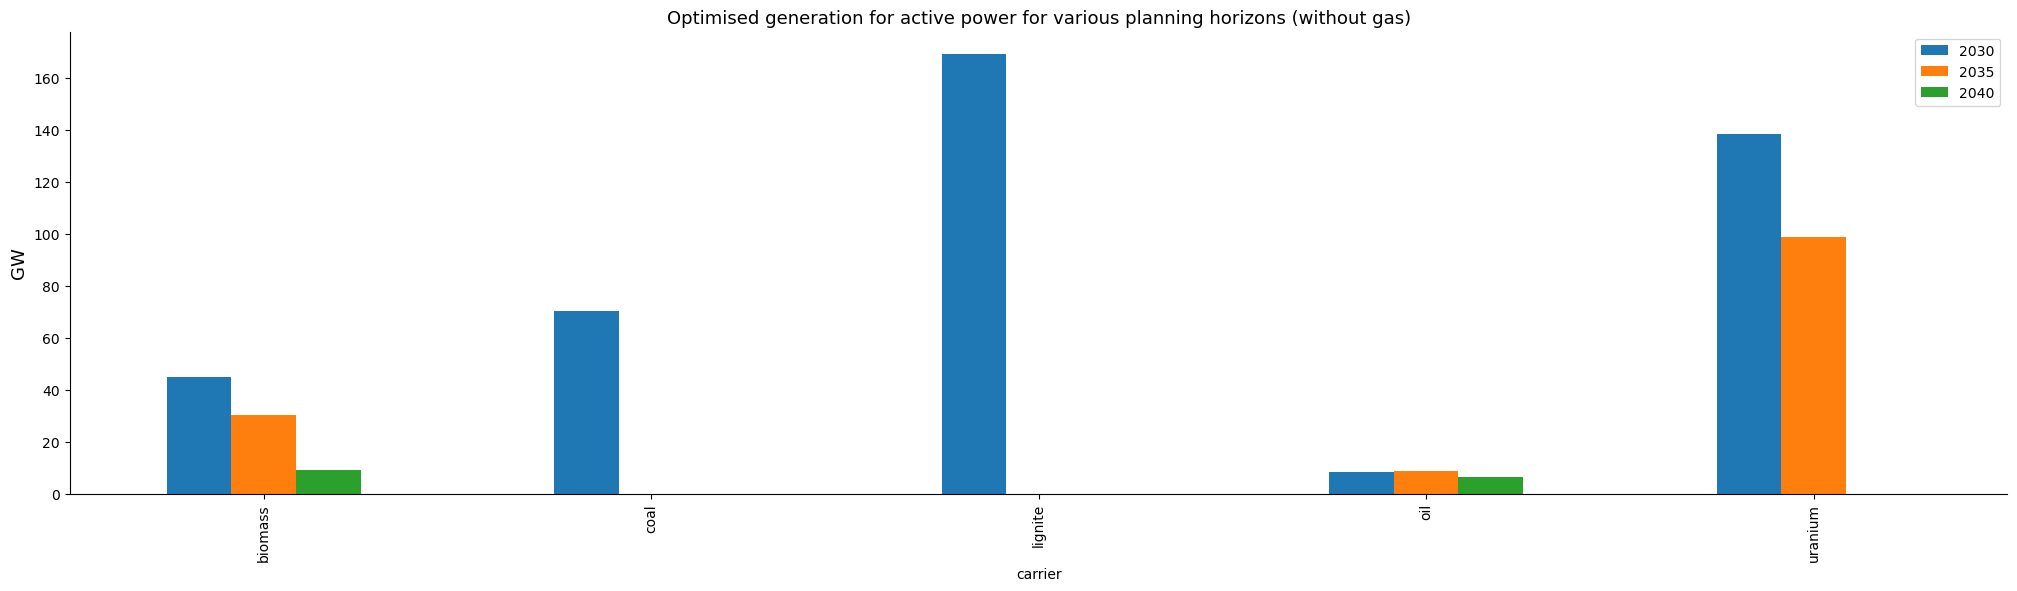

In [280]:
n_storage = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[n_y.index.isin(gens)]
    n_storage[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]]/1e3 for k, ni in n_storage.items()}, kind="bar", title="Optimised generation for active power for various planning horizons", unit="GW")

n_storage = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[n_y.index.isin([c for c in gens if c != "gas"])]
    n_storage[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]]/1e3 for k, ni in n_storage.items()}, kind="bar", title="Optimised generation for active power for various planning horizons (without gas)", unit="GW")

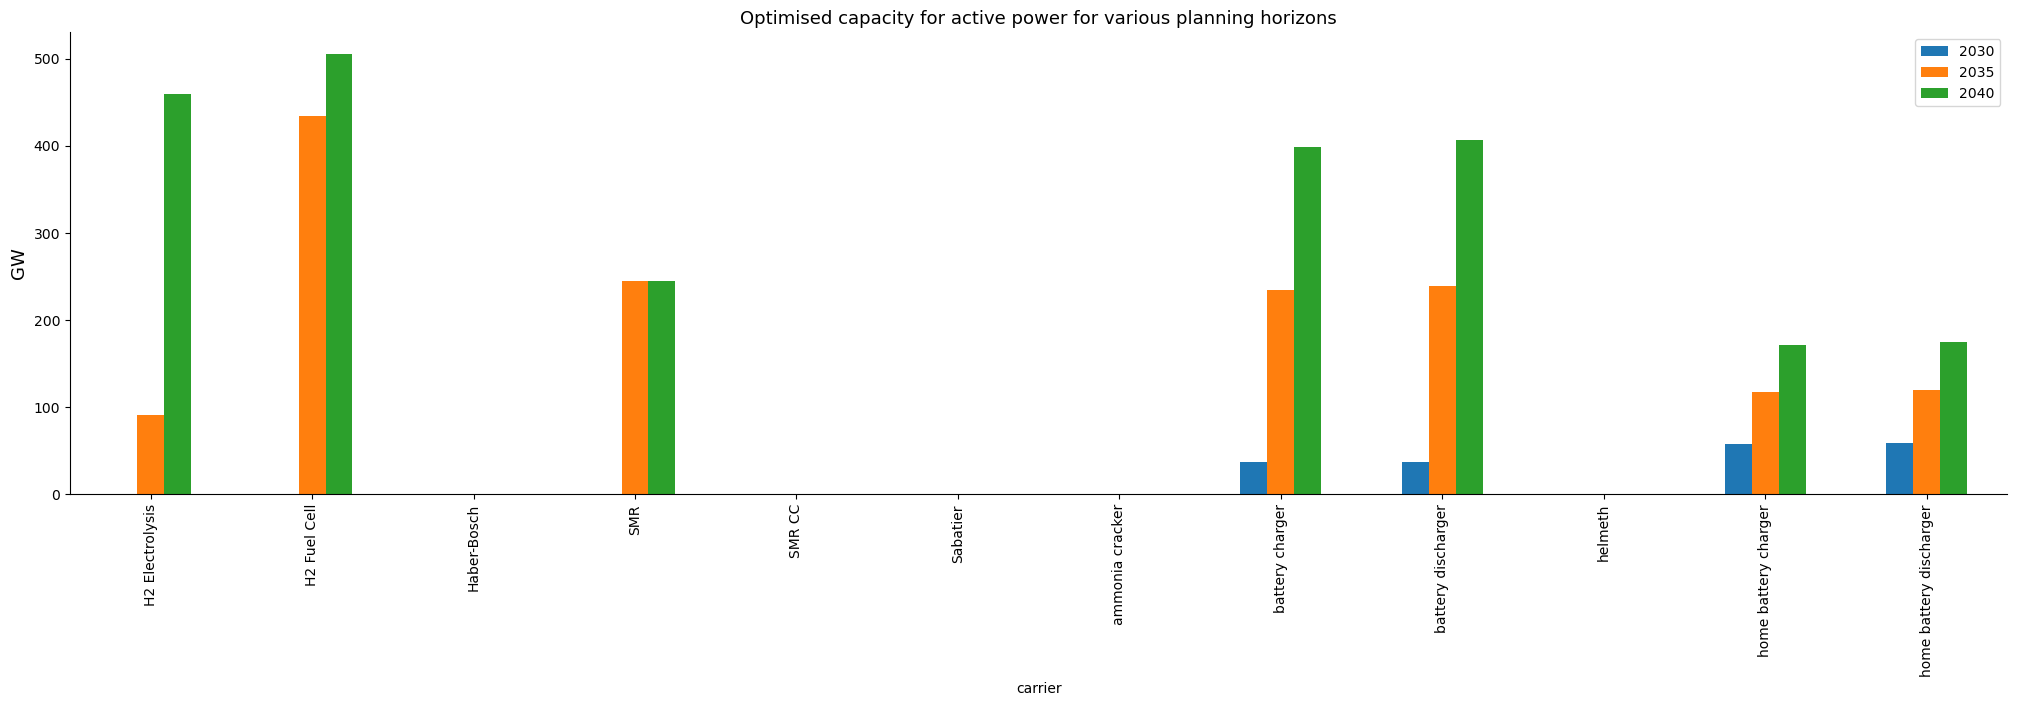

In [281]:
n_storage = {}
for y in years:
    n_y = pd.concat([n[str(y)].links.groupby(by="carrier").sum(), n[str(y)].generators.groupby(by="carrier").sum()])
    n_y = n_y.rename(index=renamer)
    n_y = n_y[n_y.index.isin(storage_exclude)]
    n_storage[y] = n_y
graph_display({k: ni.groupby(by="carrier").sum()[[var]]/1e3 for k, ni in n_storage.items()}, kind="bar", title="Optimised capacity for active power for various planning horizons", unit="GW")

## 4. Displaying optimal capacity of transmission network

Transmission network capacities for AC (brown) and DC (green) for 2030


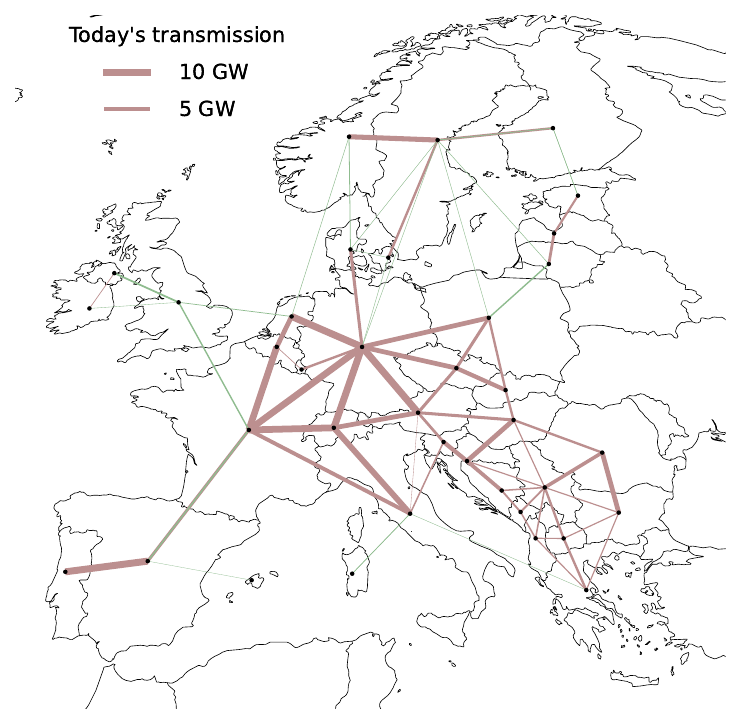

Transmission network capacities for AC (brown) and DC (green) for 2035


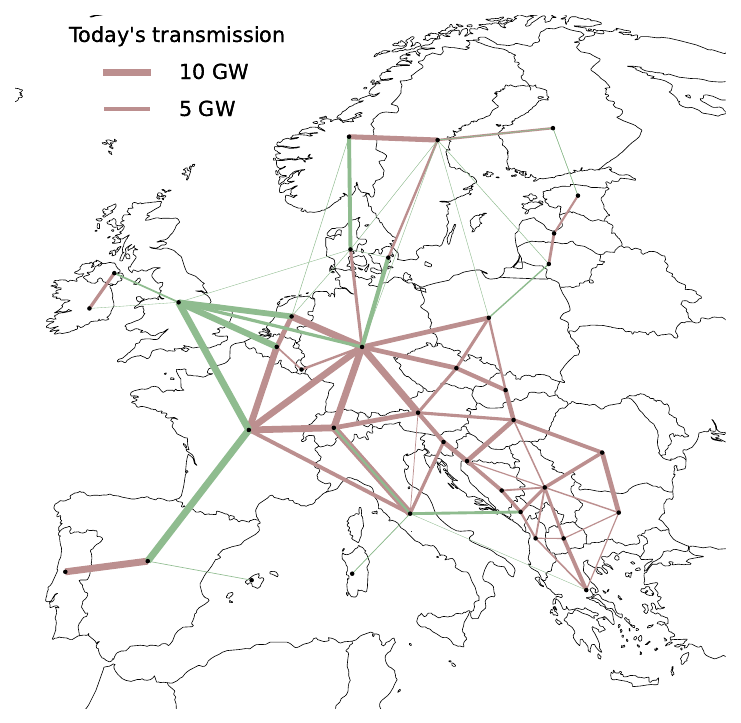

Transmission network capacities for AC (brown) and DC (green) for 2040


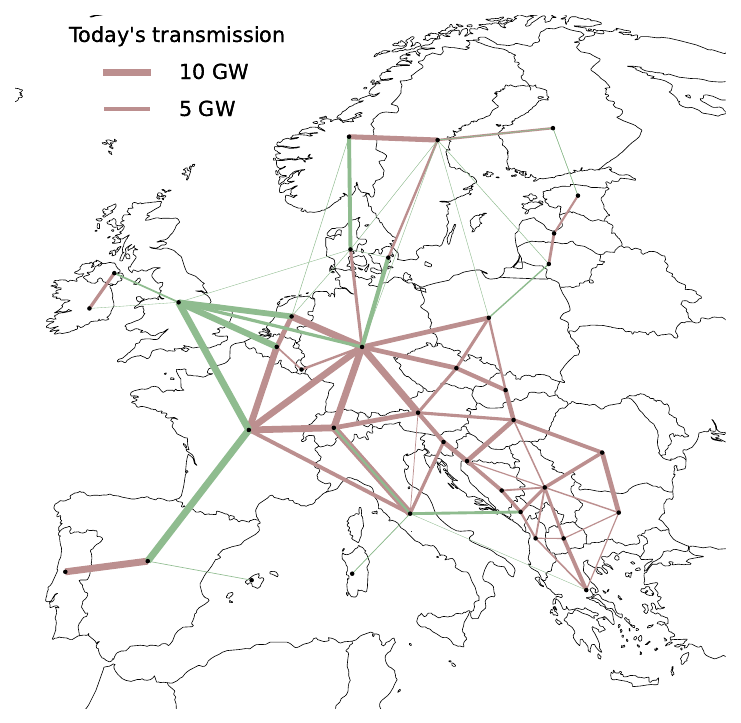

In [282]:
from IPython.display import Image

for y in years:
    filename = n_name + f"{y}-today"
    path = Path(n_path, "maps")
    file_pdf = Path(path, filename + ".pdf")
    file_png = Path(path, filename)
    ! pdftoppm {file_pdf} {file_png} -png
    print(f"Transmission network capacities for AC (brown) and DC (green) for {y}")
    display(Image(str(file_png) + "-1.png"))

H2 network for 2030


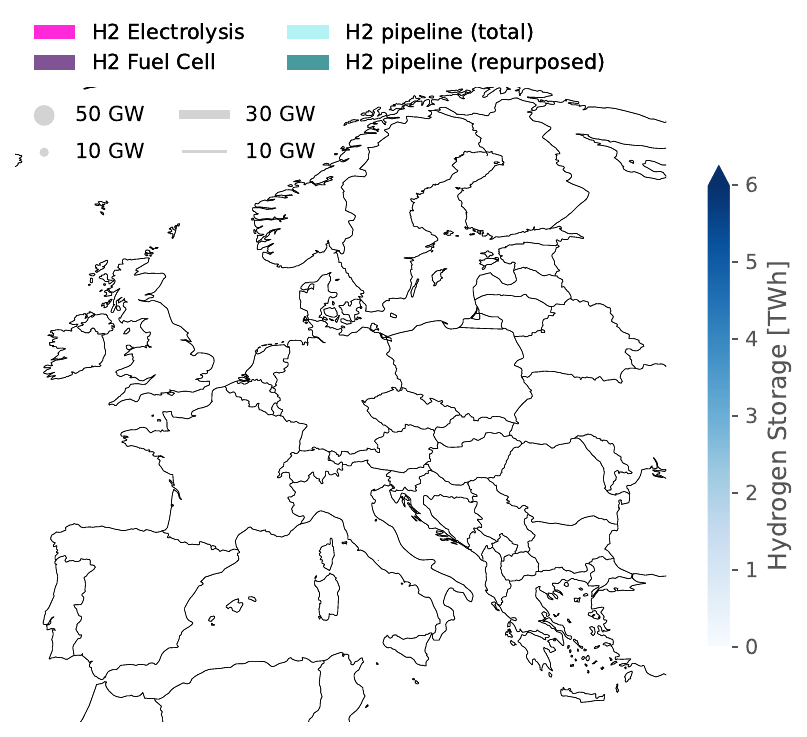

H2 network for 2035


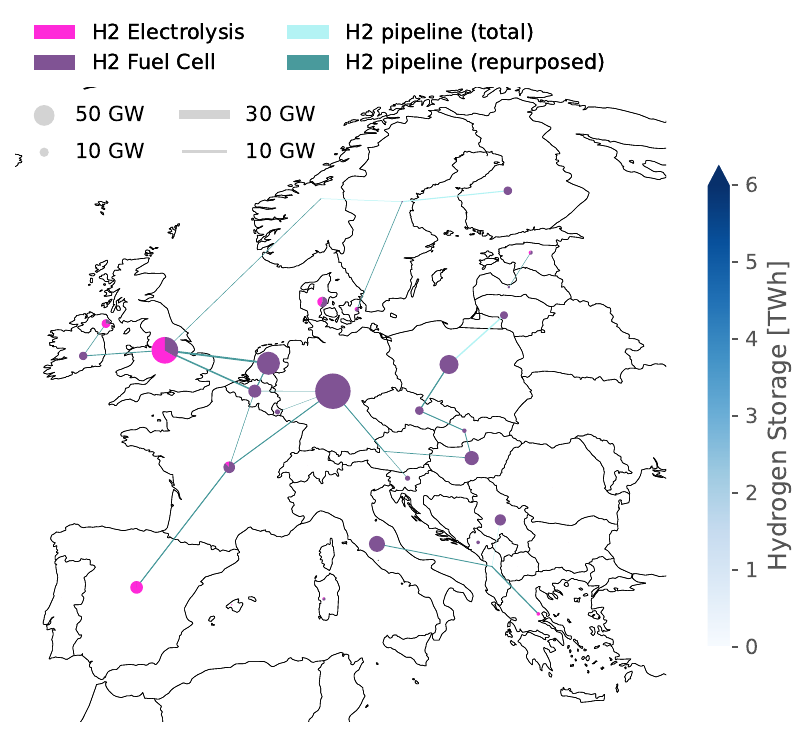

H2 network for 2040


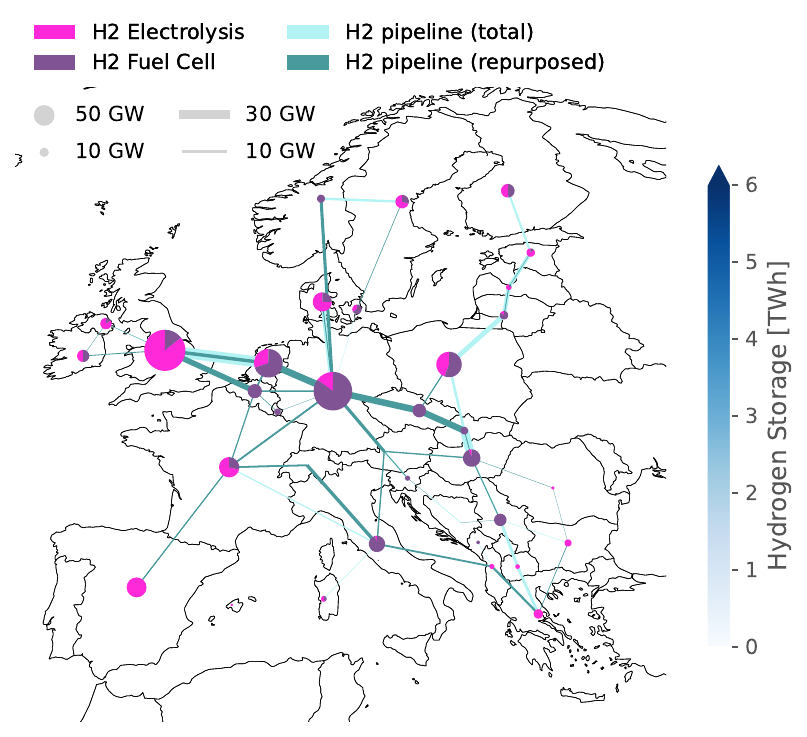

In [283]:
from IPython.display import Image

for y in years:
    filename = n_name[:-1] + f"-h2_network_{y}"
    path = Path(n_path, "maps")
    file_pdf = Path(path, filename + ".pdf")
    file_png = Path(path, filename)
    ! pdftoppm {file_pdf} {file_png} -png
    print(f"H2 network for {y}")
    display(Image(str(file_png) + "-1.png"))

## 5. Displaying annual profiles for storage units

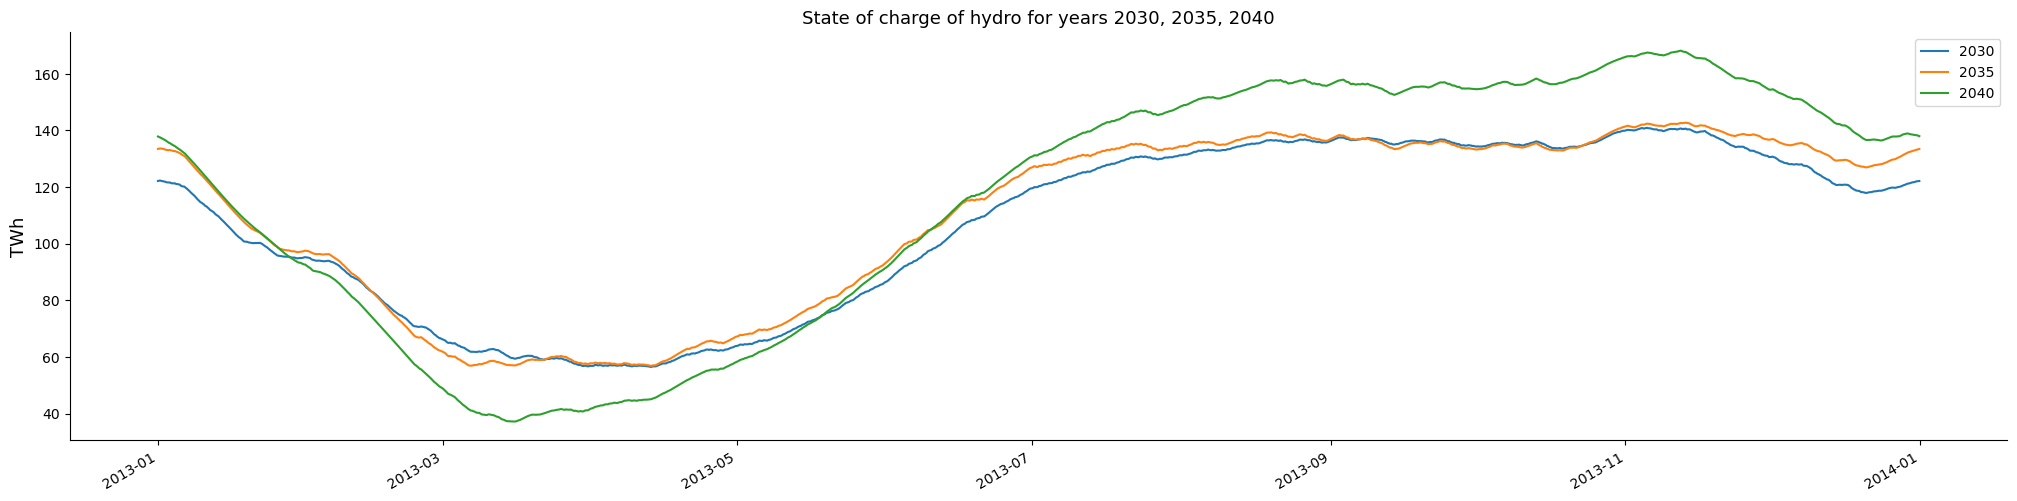

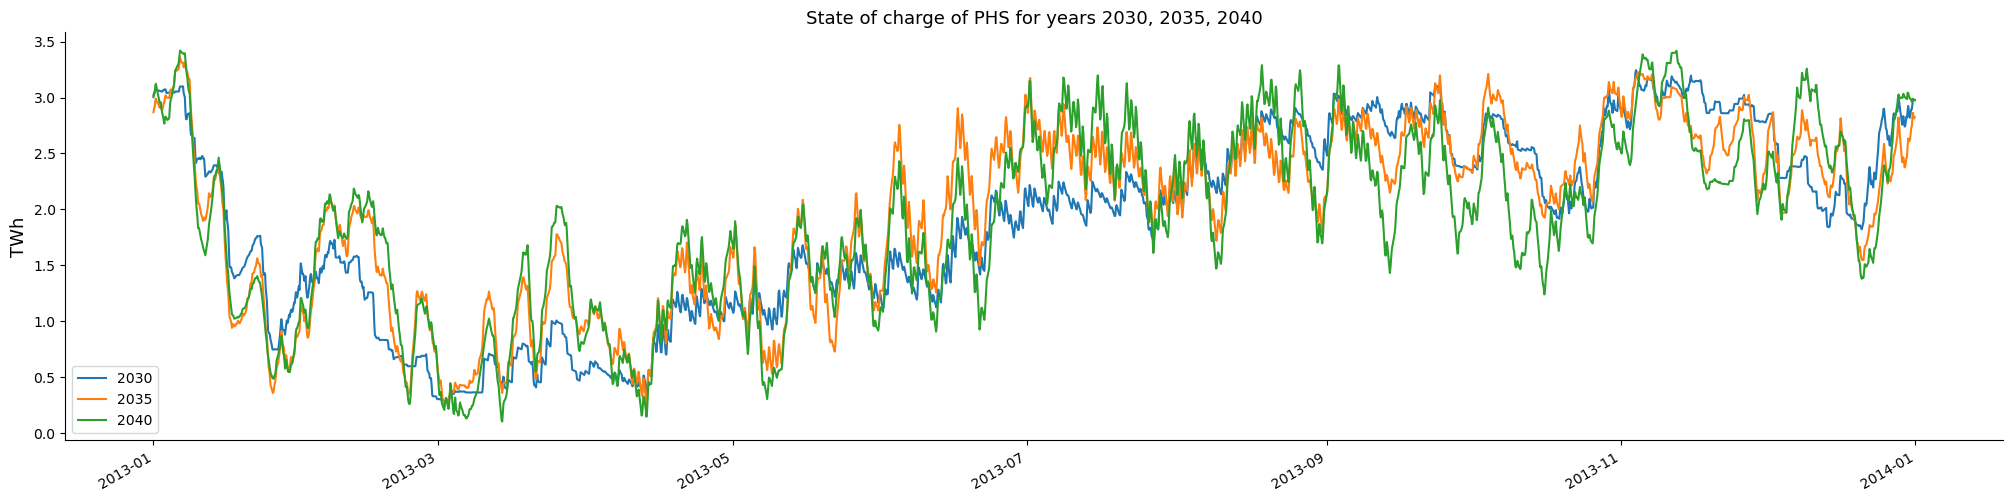

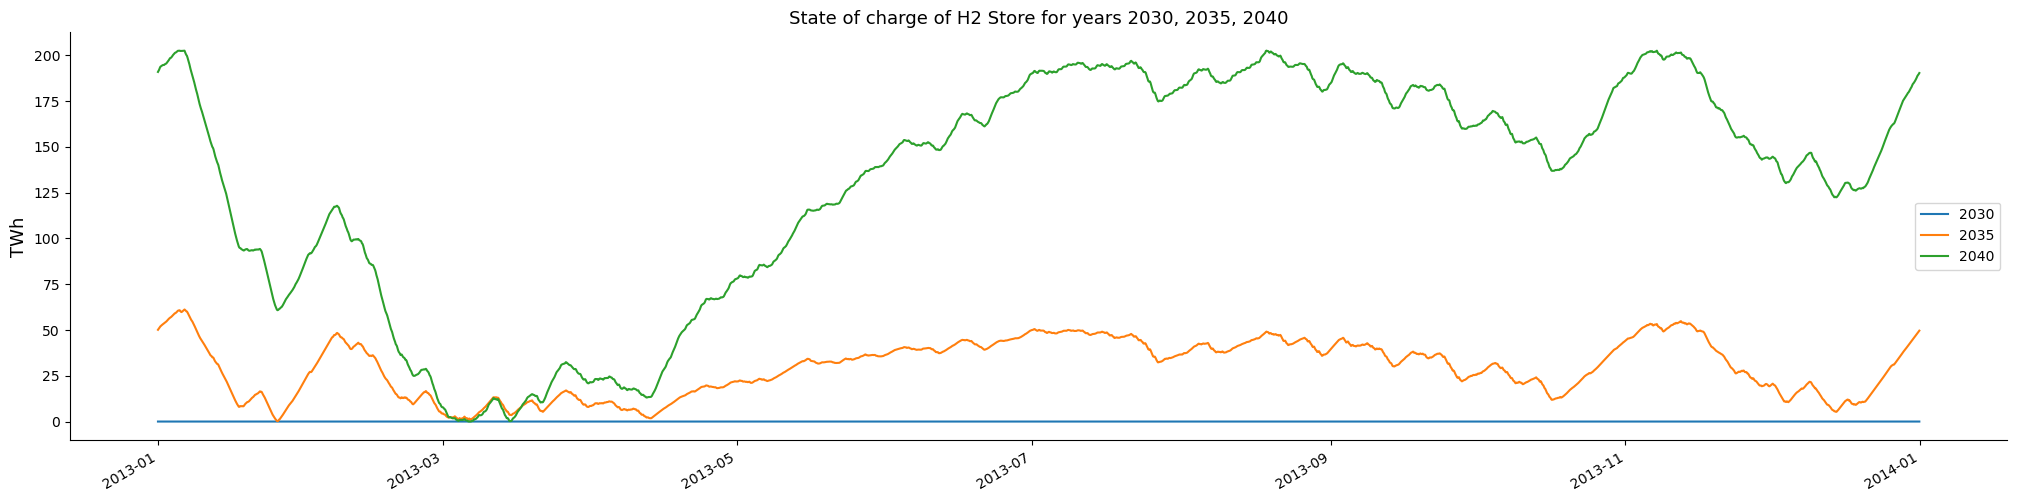

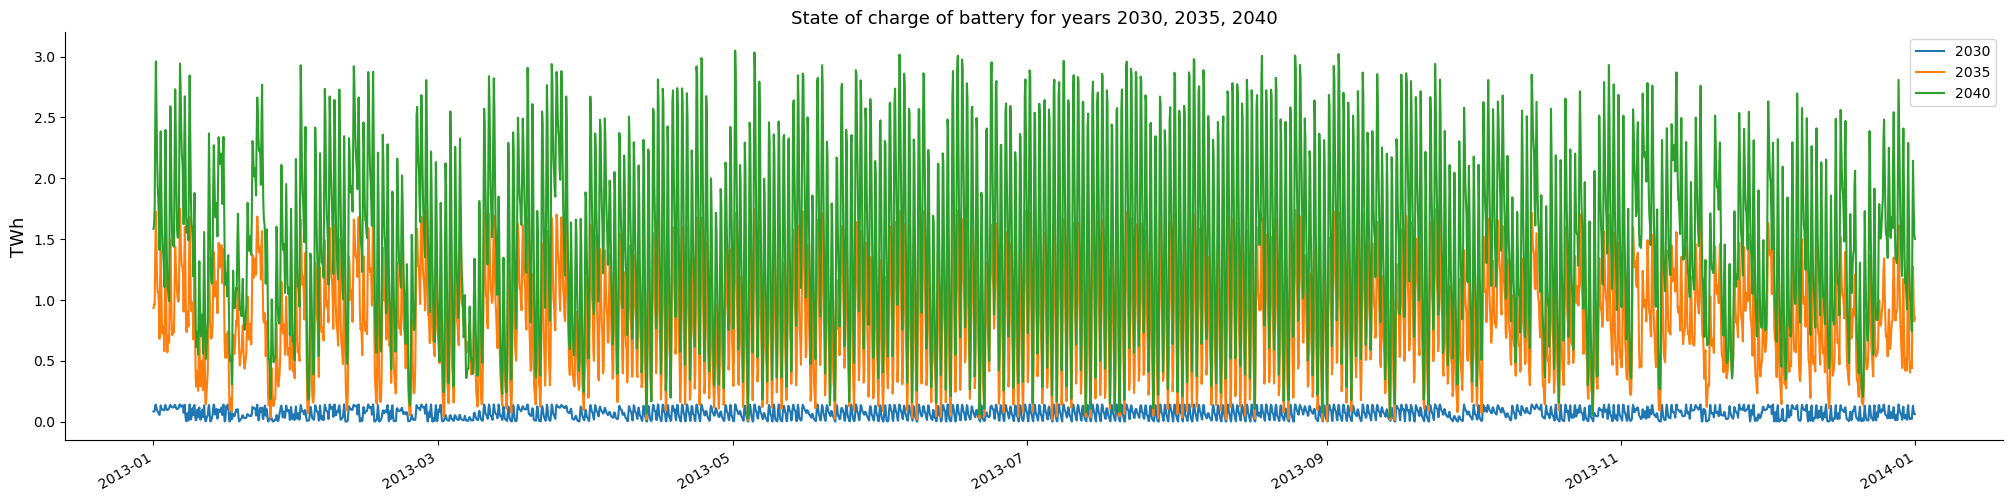

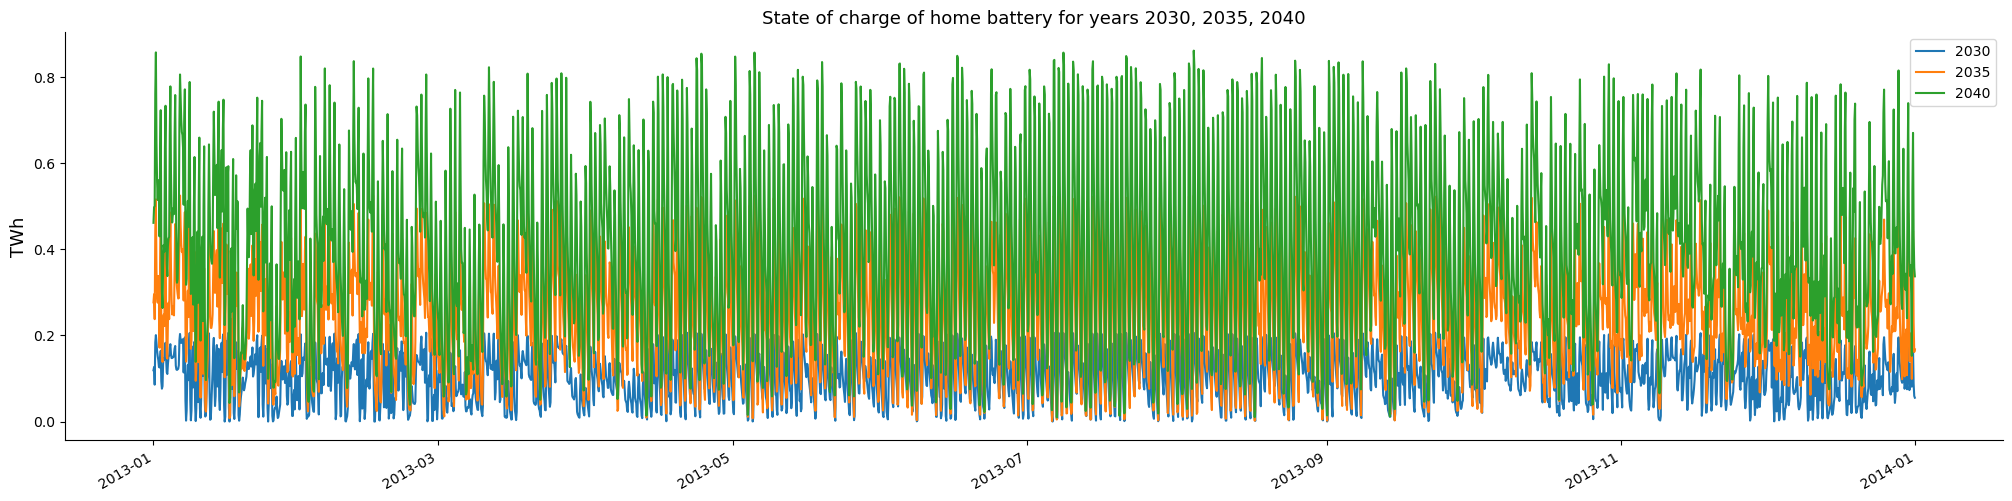

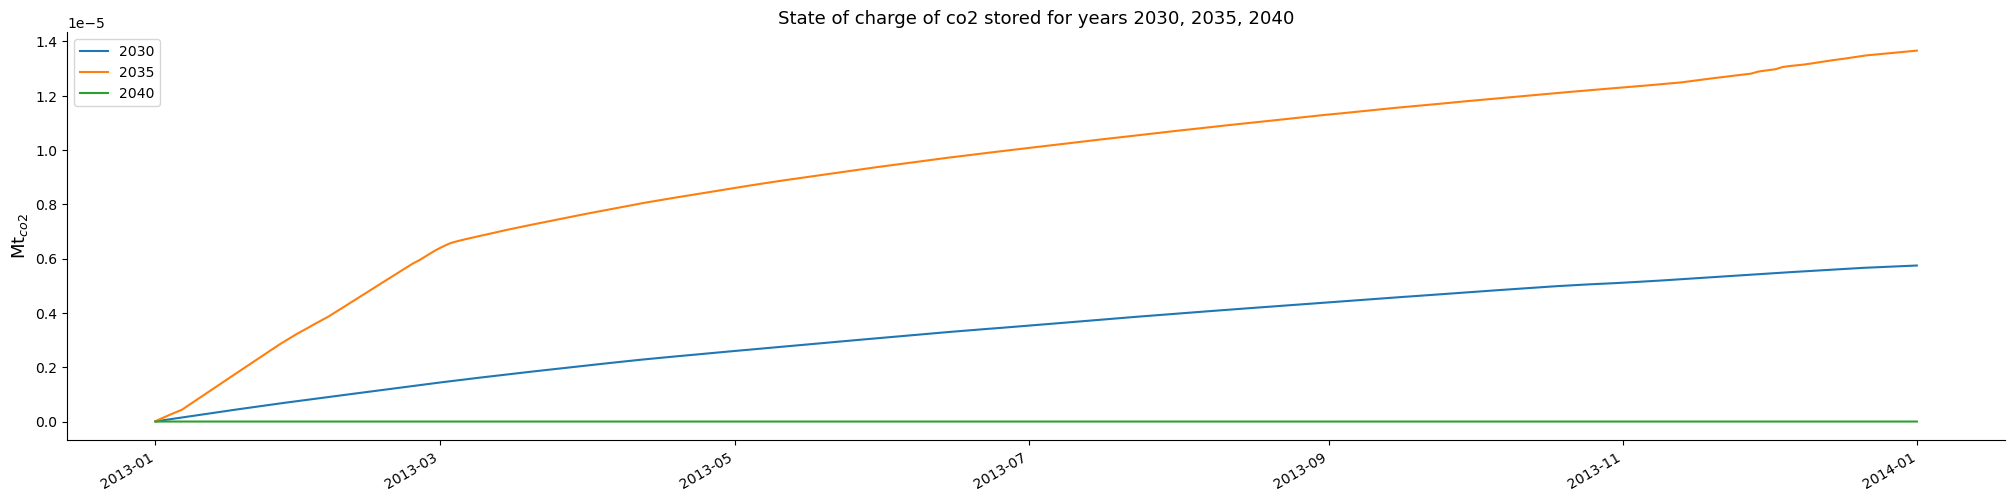

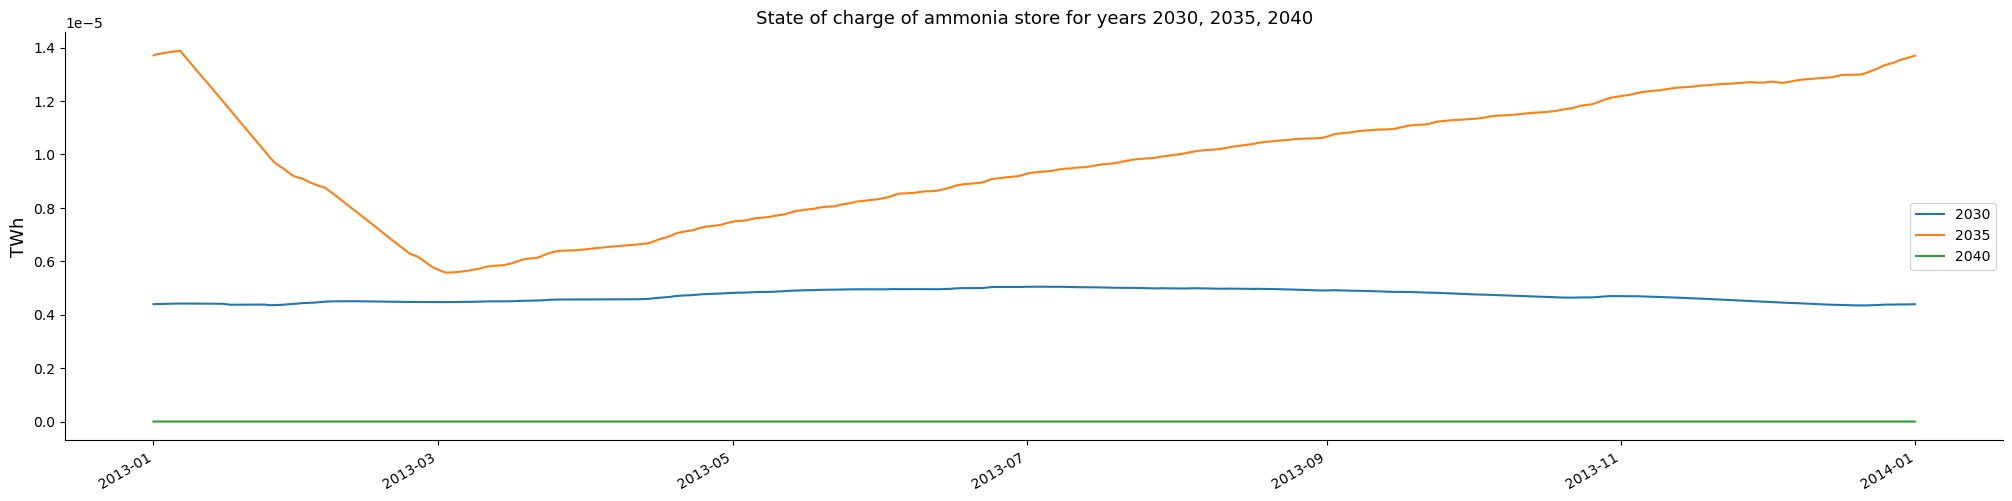

In [284]:
for carrier in ["hydro", "PHS"]:
    graph_display({k: get_state_of_charge_t(ni, carrier)/1e6 for k, ni in n.items()}, title=f"State of charge of {carrier} for years "+ ", ".join([str(y) for y in years]), unit="TWh")
for carrier in ["H2 Store", "battery", "home battery", "co2 stored", "ammonia store"]:
    graph_display({k: get_e_t(ni, carrier)/1e6 for k, ni in n.items()}, title=f"State of charge of {carrier} for years "+ ", ".join([str(y) for y in years]), unit=r"Mt$_{co2}$"if carrier =="co2 stored" else "TWh")

<AxesSubplot:xlabel='snapshot'>

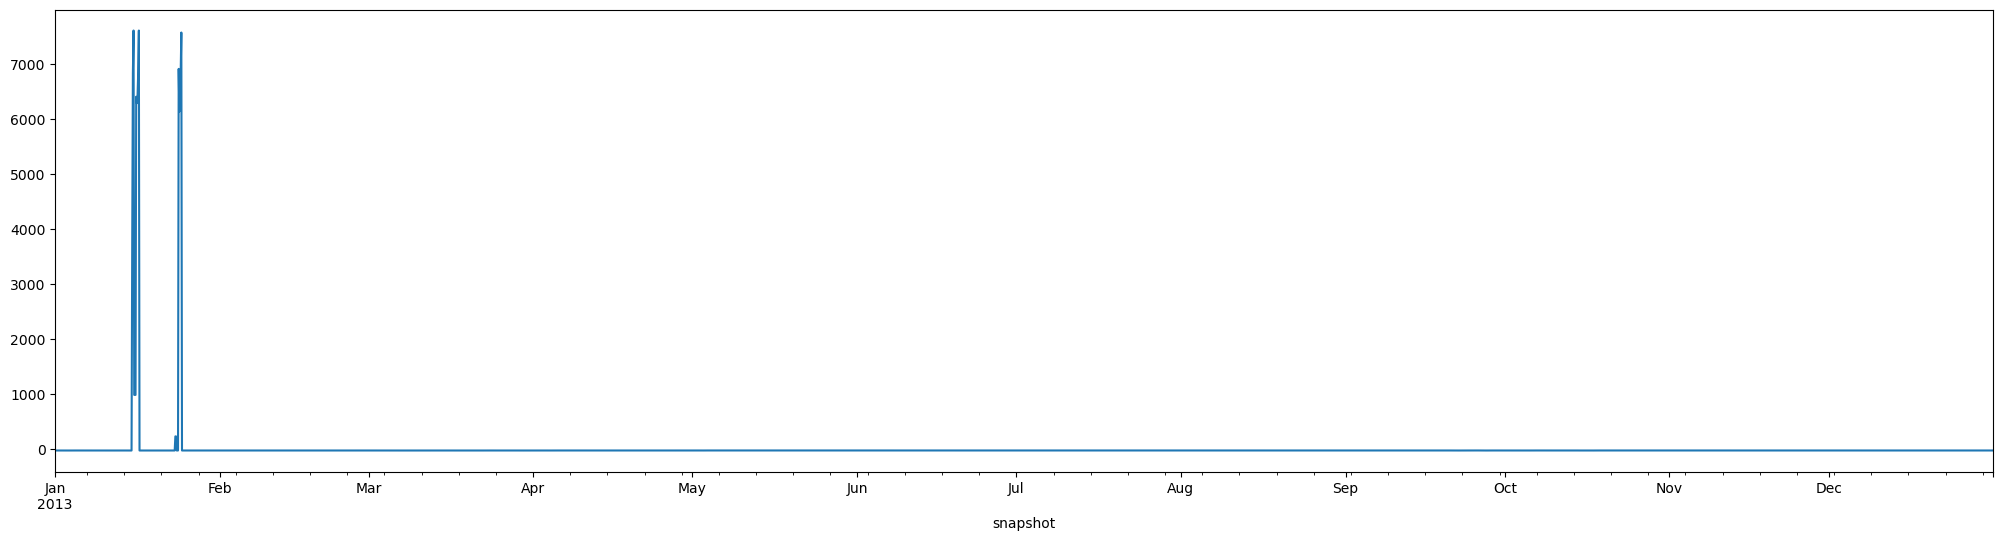

In [285]:
ni = n["2030"].stores_t
np = ni.p
np.T[np.T.index.str.contains("oil")].sum().T.plot()